# 🔮 CHRONOS: Многомерное прогнозирование временных рядов

Этот блокнот реализует многомерное прогнозирование финансовых временных рядов с использованием **CHRONOS** - предобученной foundation модели от Amazon.

## 🎯 Основные особенности

- **Многомерные данные**: используем данные из папки `/data/multivariate_series/`
- **Поэтапные признаки**: различные этапы добавления фичей согласно progressive feature analysis
- **Walk-forward прогнозирование**: честное тестирование с расширяющимся окном
- **Горизонт прогноза**: 10 точек
- **Размер теста**: 11 точек
- **Контекстное окно**: 50 точек
- **CHRONOS модели**: от tiny до large
- **Метрики**: RMSE, MAPE, DA (Directional Accuracy)

## 📊 Структура этапов признаков

1. **Этап 1**: Только цены закрытия (close)
2. **Этап 2**: + Аномалии (anomaly)
3. **Этап 3**: + Новостные настроения (weighted_score_with_decay)
4. **Этап 4**: + Базовые OHLCV признаки
5. **Этап 5**: + Технические индикаторы
6. **Этап 6**: + Статистические признаки (TSFresh)

## 🧠 Методология
- **Zero-shot прогнозирование**: CHRONOS работает без дообучения на новых рядах
- **Walk-forward валидация**: строгая проверка на будущих данных с расширяющимся окном
- **Контекстное окно**: 50 точек для каждого прогноза
- **Прогноз**: 10 точек вперед на каждом шаге


In [1]:
# Установка и импорты
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import os
from typing import List, Dict, Tuple, Optional
from datetime import datetime

# Проверка и установка пакетов
try:
    from chronos import ChronosPipeline
    print("✅ CHRONOS доступен")
except ImportError:
    print("📦 Устанавливаем CHRONOS...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "chronos-forecasting", "--quiet"])
    from chronos import ChronosPipeline
    print("✅ CHRONOS установлен и импортирован")

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Настройка визуализации
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

# Проверка доступности CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Используемое устройство: {device}")
print(f"🔥 CUDA доступна: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"🎯 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Памяти GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

print("📚 Библиотеки загружены успешно!")

✅ CHRONOS доступен
🖥️  Используемое устройство: cpu
🔥 CUDA доступна: False
📚 Библиотеки загружены успешно!


In [2]:
# Конфигурация (точно как в ML_DARTS_Multivariate)
DATA_PATH = "../../data/multivariate_series/"
OUTPUT_PATH = "results/multivariate_chronos/"
FORECAST_HORIZON = 10  # Прогнозируем на 10 точек
TEST_SIZE = 11  # Размер тестового набора
CONTEXT_WINDOW = 50  # Размер контекстного окна

# Создаем папку для результатов
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

# Список тикеров (точно как в ML_DARTS_Multivariate)
TICKERS = ['AFLT', 'LKOH', 'MOEX', 'NVTK', 'PIKK', 'SBER', 'VKCO', 'VTBR', 'X5', 'YDEX']

# Названия этапов для отображения (точно как в ML_DARTS_Multivariate)
STAGE_NAMES = {
    1: "Базовая цена (close)",
    2: "Цена + аномалии",
    3: "Цена + аномалии + новости",
    4: "Всё выше + OHLCV",
    5: "Всё выше + технические индикаторы",
    6: "Всё выше + статистические признаки"
}

# Конфигурации CHRONOS моделей
CHRONOS_MODELS = {
    'chronos-t5-tiny': {
        'model_name': 'amazon/chronos-t5-tiny',
        'description': 'Самая компактная версия (8M параметров)',
        'memory_gb': 0.5,
        'context_length': 64
    },
    'chronos-t5-mini': {
        'model_name': 'amazon/chronos-t5-mini',
        'description': 'Мини версия (20M параметров)',
        'memory_gb': 1.0,
        'context_length': 64
    },
    'chronos-t5-small': {
        'model_name': 'amazon/chronos-t5-small',
        'description': 'Малая версия (46M параметров)',
        'memory_gb': 2.0,
        'context_length': 64
    },
    'chronos-t5-base': {
        'model_name': 'amazon/chronos-t5-base',
        'description': 'Базовая версия (200M параметров)',
        'context_length': 64,
        'memory_gb': 3.0
    },
    'chronos-t5-large': {
        'model_name': 'amazon/chronos-t5-large',
        'description': 'Большая версия (710M параметров)',
        'context_length': 64,
        'memory_gb': 6.0
    }
}

print(f"Настройки:")
print(f"- Путь к данным: {DATA_PATH}")
print(f"- Горизонт прогноза: {FORECAST_HORIZON}")
print(f"- Размер тест. данных: {TEST_SIZE}")
print(f"- Размер контекстного окна: {CONTEXT_WINDOW}")
print(f"- Количество тикеров: {len(TICKERS)}")
print(f"- Папка результатов: {OUTPUT_PATH}")
print(f"- Количество CHRONOS моделей: {len(CHRONOS_MODELS)}")

Настройки:
- Путь к данным: ../../data/multivariate_series/
- Горизонт прогноза: 10
- Размер тест. данных: 11
- Размер контекстного окна: 50
- Количество тикеров: 10
- Папка результатов: results/multivariate_chronos/
- Количество CHRONOS моделей: 5


In [3]:
# Функции для подготовки признаков по этапам (точно как в ML_DARTS_Multivariate)
def prepare_features_for_stage(df: pd.DataFrame, stage: int) -> List[str]:
    """
    Подготавливает список признаков для определенного этапа
    
    Args:
        df: DataFrame с данными
        stage: номер этапа (1-6)
    
    Returns:
        List[str]: список названий колонок для данного этапа
    """
    available_features = set(df.columns)
    
    # Этап 1: Только цена закрытия
    if stage == 1:
        return ['close'] if 'close' in available_features else []
    
    # Этап 2: Цена + аномалии
    elif stage == 2:
        features = ['close']
        if 'anomaly' in available_features:
            features.append('anomaly')
        return [f for f in features if f in available_features]
    
    # Этап 3: Цена + аномалии + новости
    elif stage == 3:
        features = ['close']
        if 'anomaly' in available_features:
            features.append('anomaly')
        if 'weighted_score_with_decay' in available_features:
            features.append('weighted_score_with_decay')
        return [f for f in features if f in available_features]
    
    # Этап 4: Всё выше + OHLCV
    elif stage == 4:
        features = ['close']
        if 'anomaly' in available_features:
            features.append('anomaly')
        if 'weighted_score_with_decay' in available_features:
            features.append('weighted_score_with_decay')
        
        # Добавляем OHLCV
        ohlcv_features = ['open', 'high', 'low', 'volume']
        for feat in ohlcv_features:
            if feat in available_features:
                features.append(feat)
        
        return [f for f in features if f in available_features]
    
    # Этап 5: Всё выше + технические индикаторы
    elif stage == 5:
        features = ['close']
        if 'anomaly' in available_features:
            features.append('anomaly')
        if 'weighted_score_with_decay' in available_features:
            features.append('weighted_score_with_decay')
        
        # OHLCV
        ohlcv_features = ['open', 'high', 'low', 'volume']
        for feat in ohlcv_features:
            if feat in available_features:
                features.append(feat)
        
        # Технические индикаторы
        tech_features = ['EMA_14', 'RSI_14', 'MACD', 'return', 'ATR_14', 'VWAP']
        for feat in tech_features:
            if feat in available_features:
                features.append(feat)
        
        return [f for f in features if f in available_features]
    
    # Этап 6: Всё выше + статистические признаки
    elif stage == 6:
        features = ['close']
        if 'anomaly' in available_features:
            features.append('anomaly')
        if 'weighted_score_with_decay' in available_features:
            features.append('weighted_score_with_decay')
        
        # OHLCV
        ohlcv_features = ['open', 'high', 'low', 'volume']
        for feat in ohlcv_features:
            if feat in available_features:
                features.append(feat)
        
        # Технические индикаторы
        tech_features = ['EMA_14', 'RSI_14', 'MACD', 'return', 'ATR_14', 'VWAP']
        for feat in tech_features:
            if feat in available_features:
                features.append(feat)
        
        # Статистические признаки (выборочно TSFresh)
        tsfresh_stats = [
            'value__mean',
            'value__maximum',
            'value__minimum',
            'value__standard_deviation',
            'value__partial_autocorrelation__lag_3',
            'value__autocorrelation__lag_5',
            'value__longest_strike_above_mean'
        ]
        for feat in tsfresh_stats:
            if feat in available_features:
                features.append(feat)
        
        return [f for f in features if f in available_features]
    
    else:
        return ['close'] if 'close' in available_features else []

print("Функции для подготовки признаков созданы")

Функции для подготовки признаков созданы


In [4]:
# Вспомогательные функции для оценки (точно как в ML_DARTS_Multivariate)
def calculate_directional_accuracy(actual: np.ndarray, predicted: np.ndarray) -> float:
    """Вычисляет точность направления (DA)"""
    if len(actual) < 2 or len(predicted) < 2:
        return 0.0
    
    actual_direction = np.diff(actual) > 0
    predicted_direction = np.diff(predicted) > 0
    
    return np.mean(actual_direction == predicted_direction) * 100

def load_ticker_data(ticker: str) -> Optional[pd.DataFrame]:
    """Загружает данные для тикера (точно как в ML_DARTS_Multivariate)"""
    file_path = f"{DATA_PATH}{ticker}_multivariate.csv"
    
    if not os.path.exists(file_path):
        print(f"⚠️ Файл не найден: {file_path}")
        return None
    
    try:
        df = pd.read_csv(file_path)
        
        # Проверяем наличие timestamp колонки
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.set_index('timestamp')
        
        # Сортируем по времени
        df = df.sort_index()
        
        # Проверяем наличие основных колонок
        required_cols = ['close']
        if not all(col in df.columns for col in required_cols):
            print(f"⚠️ Отсутствуют необходимые колонки в {ticker}")
            return None
        
        print(f"✅ Загружен {ticker}: {len(df)} точек, {len(df.columns)} признаков")
        return df
        
    except Exception as e:
        print(f"❌ Ошибка загрузки {ticker}: {e}")
        return None

print("Вспомогательные функции созданы")

Вспомогательные функции созданы


In [5]:
# Основная функция для оценки CHRONOS моделей
def evaluate_chronos_model(df: pd.DataFrame, ticker: str, stage: int, model_name: str) -> Optional[Dict]:
    """
    Обучает и оценивает CHRONOS модель на данных тикера для определенного этапа
    
    Args:
        df: DataFrame с данными тикера
        ticker: название тикера
        stage: номер этапа
        model_name: название CHRONOS модели
        
    Returns:
        Dict с результатами или None при ошибке
    """
    
    try:
        # Подготавливаем признаки для этапа
        feature_columns = prepare_features_for_stage(df, stage)
        
        if len(feature_columns) == 0:
            print(f"  ⚠️ Нет доступных признаков для {ticker} на этапе {stage}")
            return None
        
        # Проверяем наличие всех колонок
        available_features = [col for col in feature_columns if col in df.columns]
        
        if len(available_features) == 0:
            print(f"  ⚠️ Нет доступных признаков для {ticker} на этапе {stage}")
            return None
        
        # Удаляем строки с NaN в выбранных признаках
        df_clean = df[available_features].dropna()
        
        if len(df_clean) < TEST_SIZE + CONTEXT_WINDOW:
            print(f"  ⚠️ Недостаточно данных для {ticker} на этапе {stage}")
            return None
        
        print(f"  🔮 Загрузка модели {model_name}...")
        
        # Загружаем CHRONOS модель
        load_start = time.time()
        pipeline = ChronosPipeline.from_pretrained(
            model_name,
            device_map=device,
            torch_dtype=torch.bfloat16 if device.type == 'cuda' else torch.float32,
        )
        load_time = time.time() - load_start
        
        print(f"  ✅ Модель загружена за {load_time:.1f}с")
        print(f"  📊 Признаки этапа {stage}: {', '.join(available_features)}")
        
        # Подготавливаем целевую переменную (цена закрытия)
        target_series = df_clean['close'].values
        
        # Walk-forward предсказание с extending window (как в ML_DARTS_Multivariate)
        predictions = []
        
        # Начинаем с контекстного окна и делаем прогнозы на последние TEST_SIZE-1 точек
        start_idx = len(target_series) - TEST_SIZE
        
        print(f"  🎯 Walk-forward прогнозирование: {FORECAST_HORIZON} шагов")
        
        step_times = []
        
        for i in range(FORECAST_HORIZON):
            step_start = time.time()
            
            # Определяем текущую позицию
            current_pos = start_idx + i
            
            # Берем контекстное окно размером CONTEXT_WINDOW
            context_start = max(0, current_pos - CONTEXT_WINDOW)
            context_end = current_pos
            
            # Контекст для CHRONOS (только цена закрытия)
            context_data = target_series[context_start:context_end]
            
            # Проверяем размер контекста
            if len(context_data) < 10:  # Минимальный размер контекста
                print(f"    ⚠️ Недостаточно данных для контекста на шаге {i+1}")
                predictions.append(np.nan)
                step_times.append(time.time() - step_start)
                continue
            
            try:
                # Подготавливаем тензор контекста
                context_tensor = torch.tensor(context_data, dtype=torch.float32).unsqueeze(0)
                
                # Делаем прогноз на 1 шаг вперед
                forecast = pipeline.predict(
                    context=context_tensor,
                    prediction_length=1,
                    num_samples=1,
                    temperature=0.2
                )
                
                # Извлекаем прогнозное значение
                y_pred = float(forecast[0, 0, 0])
                predictions.append(y_pred)
                
                step_time = time.time() - step_start
                step_times.append(step_time)
                
                if (i + 1) % 2 == 0 or (i + 1) == FORECAST_HORIZON:
                    print(f"    Шаг {i+1:2d}/{FORECAST_HORIZON}: pred={y_pred:.2f}, time={step_time:.2f}s")
                
            except Exception as e:
                print(f"    ❌ Ошибка прогноза на шаге {i+1}: {e}")
                predictions.append(np.nan)
                step_times.append(time.time() - step_start)
        
        # Получаем реальные значения для тех же позиций
        actual_values = target_series[start_idx:start_idx + FORECAST_HORIZON]
        predicted_values = np.array(predictions)
        
        # Проверяем размеры
        min_length = min(len(actual_values), len(predicted_values))
        if min_length == 0:
            print(f"  ⚠️ Пустые прогнозы для {ticker} на этапе {stage}")
            return None
        
        actual_values = actual_values[:min_length]
        predicted_values = predicted_values[:min_length]
        
        # Убираем NaN значения
        valid_mask = ~np.isnan(predicted_values)
        if np.sum(valid_mask) == 0:
            print(f"  ⚠️ Все прогнозы NaN для {ticker} на этапе {stage}")
            return None
        
        actual_valid = actual_values[valid_mask]
        predicted_valid = predicted_values[valid_mask]
        
        # Вычисляем метрики
        rmse_value = np.sqrt(mean_squared_error(actual_valid, predicted_valid))
        mape_value = mean_absolute_percentage_error(actual_valid, predicted_valid) * 100
        da_value = calculate_directional_accuracy(actual_valid, predicted_valid)
        avg_time = np.mean(step_times)
        
        print(f"  📊 Результаты: RMSE={rmse_value:.4f}, MAPE={mape_value:.2f}%, DA={da_value:.2f}%")
        
        # Очистка памяти
        del pipeline
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        return {
            'ticker': ticker,
            'stage': stage,
            'model': model_name,
            'rmse': rmse_value,
            'mape': mape_value,
            'da': da_value,
            'time': avg_time,
            'load_time': load_time,
            'predictions': predicted_values.tolist(),
            'actual': actual_values.tolist(),
            'features_count': len(available_features),
            'features': available_features,
            'valid_predictions': np.sum(valid_mask),
            'total_predictions': len(predicted_values)
        }
        
    except Exception as e:
        print(f"  ❌ Ошибка для {ticker} на этапе {stage} с моделью {model_name}: {e}")
        return None

print("Функция оценки CHRONOS моделей создана")

Функция оценки CHRONOS моделей создана


## 🚀 Запуск экспериментов

Теперь проведем эксперименты для всех тикеров, этапов и CHRONOS моделей.


In [6]:
# Запуск основных экспериментов
results = []

# Выбираем модели в зависимости от доступных ресурсов
if device.type == 'cuda':
    models_to_test = list(CHRONOS_MODELS.keys())
    print("🔥 GPU доступно - используем все CHRONOS модели")
else:
    # На CPU используем только легкие модели
    models_to_test = list(CHRONOS_MODELS.keys())#['chronos-t5-tiny', 'chronos-t5-mini']
    print("💻 CPU режим - используем только легкие CHRONOS модели")

# Этапы для тестирования (как в ML_DARTS_Multivariate)
stages_to_test = [1, 6]

print("🔬 Начинаем эксперименты с многомерными CHRONOS моделями")
print("=" * 60)

print(f"📊 Модели для тестирования: {models_to_test}")
print(f"🎯 Этапы для тестирования: {stages_to_test}")

total_experiments = len(TICKERS) * len(stages_to_test) * len(models_to_test)
current_experiment = 0

start_time = time.time()

for ticker in TICKERS:
    print(f"\\n📊 Обрабатываем тикер: {ticker}")
    
    # Загружаем данные
    df = load_ticker_data(ticker)
    if df is None:
        continue
    
    for stage in stages_to_test:
        print(f"\\n  🎯 Этап {stage}: {STAGE_NAMES.get(stage, 'Неизвестный этап')}")
        
        for model_key in models_to_test:
            current_experiment += 1
            progress = (current_experiment / total_experiments) * 100
            
            model_config = CHRONOS_MODELS[model_key]
            model_name = model_config['model_name']
            
            print(f"\\n    🔮 [{current_experiment:3d}/{total_experiments}] {model_key} ({progress:.1f}%)")
            print(f"        {model_config['description']}")
            
            # Запускаем оценку модели
            result = evaluate_chronos_model(df, ticker, stage, model_name)
            
            if result is not None:
                # Добавляем дополнительную информацию
                result['model_key'] = model_key
                result['experiment_id'] = current_experiment
                results.append(result)
                
                print(f"        ✅ Успешно завершен")
            else:
                print(f"        ❌ Завершен с ошибкой")
            
            # Принудительная очистка памяти между экспериментами
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

# Финальная статистика
end_time = time.time()
total_time = end_time - start_time

print(f"\\n" + "=" * 60)
print(f"🎉 ЭКСПЕРИМЕНТЫ ЗАВЕРШЕНЫ!")
print(f"=" * 60)
print(f"⏱️  Общее время: {total_time:.1f} секунд ({total_time/60:.1f} минут)")
print(f"✅ Успешных экспериментов: {len(results)}/{total_experiments}")

if len(results) > 0:
    success_rate = len(results) / total_experiments * 100
    print(f"📊 Успешность: {success_rate:.1f}%")
    
    # Показываем первые результаты
    print(f"\\n📋 Первые результаты:")
    for i, result in enumerate(results[:3]):
        print(f"   {i+1}. {result['ticker']} (Этап {result['stage']}, {result['model_key']})")
        print(f"      RMSE: {result['rmse']:.4f}, MAPE: {result['mape']:.2f}%, DA: {result['da']:.2f}%")
else:
    print(f"❌ Нет успешных результатов!")

💻 CPU режим - используем только легкие CHRONOS модели
🔬 Начинаем эксперименты с многомерными CHRONOS моделями
📊 Модели для тестирования: ['chronos-t5-tiny', 'chronos-t5-mini', 'chronos-t5-small', 'chronos-t5-base', 'chronos-t5-large']
🎯 Этапы для тестирования: [1, 6]
\n📊 Обрабатываем тикер: AFLT
✅ Загружен AFLT: 2356 точек, 918 признаков
\n  🎯 Этап 1: Базовая цена (close)
\n    🔮 [  1/100] chronos-t5-tiny (1.0%)
        Самая компактная версия (8M параметров)
  🔮 Загрузка модели amazon/chronos-t5-tiny...
  ✅ Модель загружена за 4.8с
  📊 Признаки этапа 1: close
  🎯 Walk-forward прогнозирование: 10 шагов
    Шаг  2/10: pred=70.90, time=0.01s
    Шаг  4/10: pred=73.88, time=0.01s
    Шаг  6/10: pred=72.28, time=0.01s
    Шаг  8/10: pred=73.88, time=0.01s
    Шаг 10/10: pred=72.86, time=0.01s
  📊 Результаты: RMSE=1.3920, MAPE=1.67%, DA=44.44%
        ✅ Успешно завершен
\n    🔮 [  2/100] chronos-t5-mini (2.0%)
        Мини версия (20M параметров)
  🔮 Загрузка модели amazon/chronos-t5-mini..

## 📊 Анализ результатов

Проанализируем полученные результаты и создадим итоговые таблицы и визуализации.


In [7]:
# Создание сводной таблицы результатов
if results:
    df_results = pd.DataFrame(results)
    
    print("📋 СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ CHRONOS")
    print("=" * 80)
    
    # Основная информация
    print(f"\\n📊 Общая статистика:")
    print(f"   Всего экспериментов: {len(results)}")
    print(f"   Уникальных тикеров: {df_results['ticker'].nunique()}")
    print(f"   Уникальных моделей: {df_results['model_key'].nunique()}")
    print(f"   Уникальных этапов: {df_results['stage'].nunique()}")
    
    # Сводная статистика по моделям
    print("\\n🤖 Средние метрики по CHRONOS моделям:")
    model_stats = df_results.groupby('model_key').agg({
        'rmse': ['mean', 'std', 'min', 'max'],
        'mape': ['mean', 'std', 'min', 'max'], 
        'da': ['mean', 'std', 'min', 'max'],
        'time': ['mean', 'std'],
        'load_time': ['mean', 'std']
    }).round(4)
    
    model_stats.columns = ['_'.join(col).strip() for col in model_stats.columns]
    print(model_stats)
    
    # Сводная статистика по этапам
    print("\\n📈 Средние метрики по этапам:")
    stage_stats = df_results.groupby('stage').agg({
        'rmse': ['mean', 'std', 'min', 'max'],
        'mape': ['mean', 'std', 'min', 'max'],
        'da': ['mean', 'std', 'min', 'max'],
        'features_count': ['mean', 'std']
    }).round(4)
    
    stage_stats.columns = ['_'.join(col).strip() for col in stage_stats.columns]
    print(stage_stats)
    
    # Лучшие результаты
    print("\\n🏆 ЛУЧШИЕ РЕЗУЛЬТАТЫ:")
    
    # Лучший по RMSE
    best_rmse = df_results.loc[df_results['rmse'].idxmin()]
    print(f"\\n🥇 Лучший RMSE: {best_rmse['rmse']:.4f}")
    print(f"   Тикер: {best_rmse['ticker']}, Модель: {best_rmse['model_key']}, Этап: {best_rmse['stage']}")
    print(f"   Признаков: {best_rmse['features_count']}")
    print(f"   MAPE: {best_rmse['mape']:.2f}%, DA: {best_rmse['da']:.2f}%")
    print(f"   Время прогноза: {best_rmse['time']*1000:.0f}мс")
    
    # Лучший по MAPE
    best_mape = df_results.loc[df_results['mape'].idxmin()]
    print(f"\\n🥈 Лучший MAPE: {best_mape['mape']:.2f}%")
    print(f"   Тикер: {best_mape['ticker']}, Модель: {best_mape['model_key']}, Этап: {best_mape['stage']}")
    print(f"   Признаков: {best_mape['features_count']}")
    print(f"   RMSE: {best_mape['rmse']:.4f}, DA: {best_mape['da']:.2f}%")
    print(f"   Время прогноза: {best_mape['time']*1000:.0f}мс")
    
    # Лучший по DA
    best_da = df_results.loc[df_results['da'].idxmax()]
    print(f"\\n🥉 Лучший DA: {best_da['da']:.2f}%")
    print(f"   Тикер: {best_da['ticker']}, Модель: {best_da['model_key']}, Этап: {best_da['stage']}")
    print(f"   Признаков: {best_da['features_count']}")
    print(f"   RMSE: {best_da['rmse']:.4f}, MAPE: {best_da['mape']:.2f}%")
    print(f"   Время прогноза: {best_da['time']*1000:.0f}мс")
    
    # Сохранение результатов
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    csv_file = f"{OUTPUT_PATH}multivariate_chronos_results_{timestamp}.csv"
    df_results.to_csv(csv_file, index=False)
    print(f"\\n💾 Результаты сохранены в файл: {csv_file}")
    
    # Детальная таблица
    print(f"\\n📋 Детальная таблица (первые 10 результатов):")
    display_columns = ['ticker', 'stage', 'model_key', 'rmse', 'mape', 'da', 'features_count']
    print(df_results[display_columns].head(10).to_string(index=False))
    
else:
    print("❌ Нет результатов для анализа!")

📋 СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ CHRONOS
\n📊 Общая статистика:
   Всего экспериментов: 100
   Уникальных тикеров: 10
   Уникальных моделей: 5
   Уникальных этапов: 2
\n🤖 Средние метрики по CHRONOS моделям:
                  rmse_mean  rmse_std  rmse_min  rmse_max  mape_mean  \
model_key                                                              
chronos-t5-base     31.1455   32.8458    1.4201   91.8083     2.0748   
chronos-t5-large    30.7886   32.2468    1.4678   89.2512     2.0084   
chronos-t5-mini     32.2603   35.4014    1.4648  101.3078     2.0777   
chronos-t5-small    31.0239   32.4731    1.3227   94.3999     2.0442   
chronos-t5-tiny     30.8636   33.0411    1.3920   90.6598     1.9877   

                  mape_std  mape_min  mape_max  da_mean   da_std   da_min  \
model_key                                                                   
chronos-t5-base     0.6456    1.0118    3.3330  47.7778  12.0104  33.3333   
chronos-t5-large    0.6985    1.1299    3.2746  51.1111  12.6

📊 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ CHRONOS
📊 График сохранен: results/multivariate_chronos/multivariate_chronos_comparison_20250622_112612.png


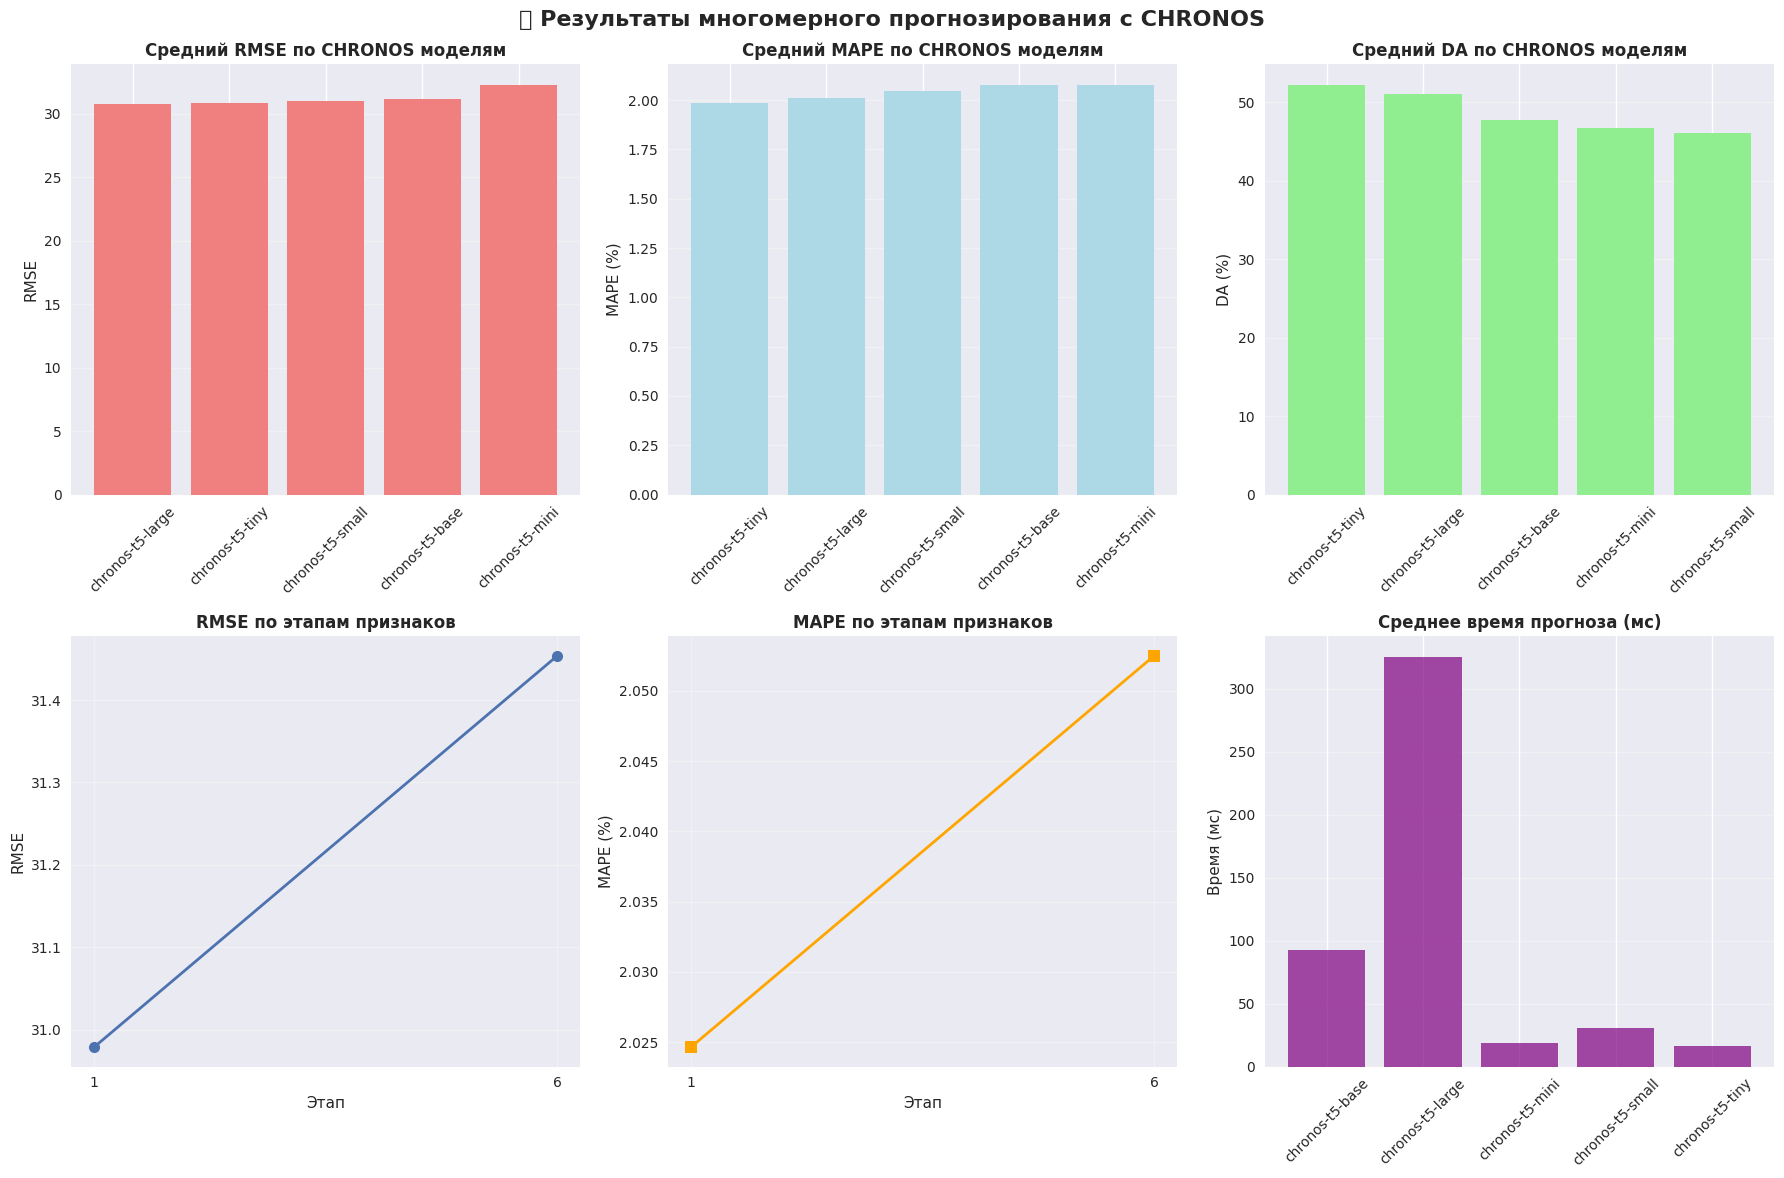

\n📈 Детальное сравнение по тикерам:
📊 Детальная визуализация сохранена: results/multivariate_chronos/chronos_detailed_comparison_20250622_112612.png


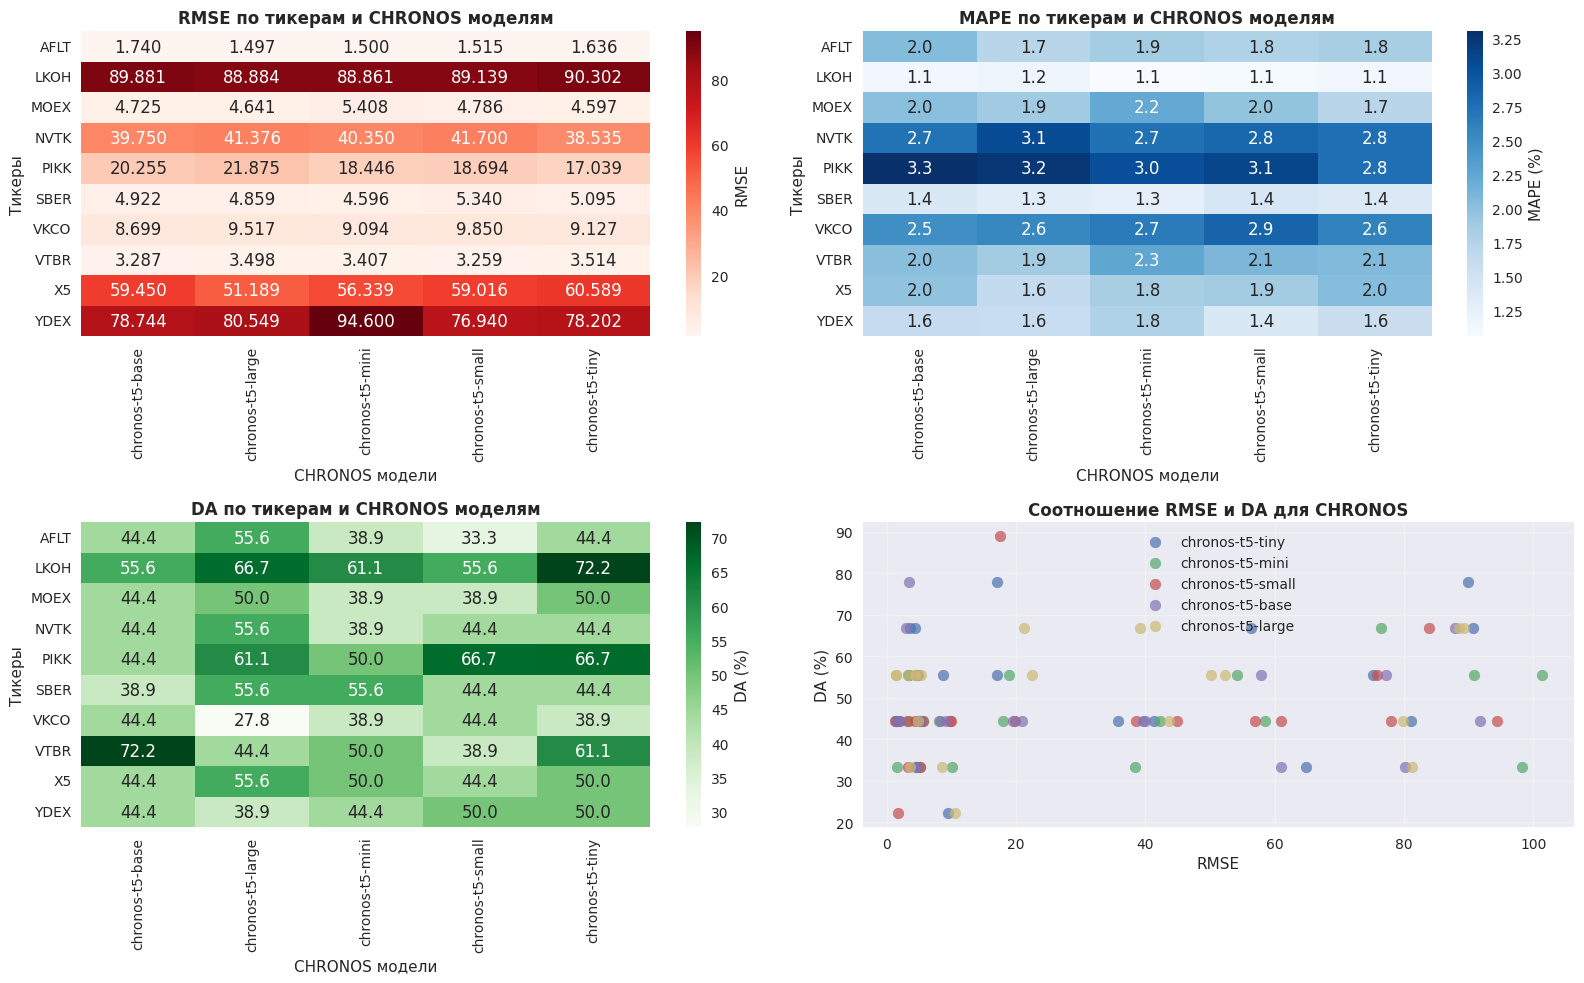

In [8]:
# Визуализация результатов
if results:
    print("📊 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ CHRONOS")
    print("=" * 50)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🔮 Результаты многомерного прогнозирования с CHRONOS', fontsize=16, fontweight='bold')
    
    # 1. RMSE по моделям
    model_rmse = df_results.groupby('model_key')['rmse'].mean().sort_values()
    axes[0,0].bar(range(len(model_rmse)), model_rmse.values, color='lightcoral')
    axes[0,0].set_title('Средний RMSE по CHRONOS моделям', fontweight='bold')
    axes[0,0].set_ylabel('RMSE')
    axes[0,0].set_xticks(range(len(model_rmse)))
    axes[0,0].set_xticklabels(model_rmse.index, rotation=45)
    axes[0,0].grid(axis='y', alpha=0.3)
    
    # 2. MAPE по моделям
    model_mape = df_results.groupby('model_key')['mape'].mean().sort_values()
    axes[0,1].bar(range(len(model_mape)), model_mape.values, color='lightblue')
    axes[0,1].set_title('Средний MAPE по CHRONOS моделям', fontweight='bold')
    axes[0,1].set_ylabel('MAPE (%)')
    axes[0,1].set_xticks(range(len(model_mape)))
    axes[0,1].set_xticklabels(model_mape.index, rotation=45)
    axes[0,1].grid(axis='y', alpha=0.3)
    
    # 3. DA по моделям
    model_da = df_results.groupby('model_key')['da'].mean().sort_values(ascending=False)
    axes[0,2].bar(range(len(model_da)), model_da.values, color='lightgreen')
    axes[0,2].set_title('Средний DA по CHRONOS моделям', fontweight='bold')
    axes[0,2].set_ylabel('DA (%)')
    axes[0,2].set_xticks(range(len(model_da)))
    axes[0,2].set_xticklabels(model_da.index, rotation=45)
    axes[0,2].grid(axis='y', alpha=0.3)
    
    # 4. RMSE по этапам
    if df_results['stage'].nunique() > 1:
        stage_rmse = df_results.groupby('stage')['rmse'].mean()
        axes[1,0].plot(stage_rmse.index, stage_rmse.values, marker='o', linewidth=2, markersize=8)
        axes[1,0].set_title('RMSE по этапам признаков', fontweight='bold')
        axes[1,0].set_xlabel('Этап')
        axes[1,0].set_ylabel('RMSE')
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].set_xticks(stage_rmse.index)
    else:
        axes[1,0].text(0.5, 0.5, 'Только один этап\\nв данных', ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('RMSE по этапам признаков', fontweight='bold')
    
    # 5. MAPE по этапам
    if df_results['stage'].nunique() > 1:
        stage_mape = df_results.groupby('stage')['mape'].mean()
        axes[1,1].plot(stage_mape.index, stage_mape.values, marker='s', linewidth=2, markersize=8, color='orange')
        axes[1,1].set_title('MAPE по этапам признаков', fontweight='bold')
        axes[1,1].set_xlabel('Этап')
        axes[1,1].set_ylabel('MAPE (%)')
        axes[1,1].grid(True, alpha=0.3)
        axes[1,1].set_xticks(stage_mape.index)
    else:
        axes[1,1].text(0.5, 0.5, 'Только один этап\\nв данных', ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('MAPE по этапам признаков', fontweight='bold')
    
    # 6. Время прогноза по моделям
    model_time = df_results.groupby('model_key')['time'].mean() * 1000  # в миллисекундах
    axes[1,2].bar(range(len(model_time)), model_time.values, color='purple', alpha=0.7)
    axes[1,2].set_title('Среднее время прогноза (мс)', fontweight='bold')
    axes[1,2].set_ylabel('Время (мс)')
    axes[1,2].set_xticks(range(len(model_time)))
    axes[1,2].set_xticklabels(model_time.index, rotation=45)
    axes[1,2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    # Сохраняем график
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    plot_file = f"{OUTPUT_PATH}multivariate_chronos_comparison_{timestamp}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"📊 График сохранен: {plot_file}")
    
    plt.show()
    
    # Дополнительная визуализация - сравнение моделей по тикерам
    if len(df_results) > 0:
        print("\\n📈 Детальное сравнение по тикерам:")
        
        plt.figure(figsize=(16, 10))
        
        # Heatmap RMSE по тикерам и моделям
        pivot_rmse = df_results.pivot_table(values='rmse', index='ticker', columns='model_key', aggfunc='mean')
        
        plt.subplot(2, 2, 1)
        sns.heatmap(pivot_rmse, annot=True, fmt='.3f', cmap='Reds', cbar_kws={'label': 'RMSE'})
        plt.title('RMSE по тикерам и CHRONOS моделям', fontweight='bold')
        plt.ylabel('Тикеры')
        plt.xlabel('CHRONOS модели')
        
        # Heatmap MAPE по тикерам и моделям
        pivot_mape = df_results.pivot_table(values='mape', index='ticker', columns='model_key', aggfunc='mean')
        
        plt.subplot(2, 2, 2)
        sns.heatmap(pivot_mape, annot=True, fmt='.1f', cmap='Blues', cbar_kws={'label': 'MAPE (%)'})
        plt.title('MAPE по тикерам и CHRONOS моделям', fontweight='bold')
        plt.ylabel('Тикеры')
        plt.xlabel('CHRONOS модели')
        
        # Heatmap DA по тикерам и моделям
        pivot_da = df_results.pivot_table(values='da', index='ticker', columns='model_key', aggfunc='mean')
        
        plt.subplot(2, 2, 3)
        sns.heatmap(pivot_da, annot=True, fmt='.1f', cmap='Greens', cbar_kws={'label': 'DA (%)'})
        plt.title('DA по тикерам и CHRONOS моделям', fontweight='bold')
        plt.ylabel('Тикеры')
        plt.xlabel('CHRONOS модели')
        
        # Scatter plot RMSE vs DA
        plt.subplot(2, 2, 4)
        for model in df_results['model_key'].unique():
            model_data = df_results[df_results['model_key'] == model]
            plt.scatter(model_data['rmse'], model_data['da'], label=model, alpha=0.7, s=60)
        
        plt.xlabel('RMSE')
        plt.ylabel('DA (%)')
        plt.title('Соотношение RMSE и DA для CHRONOS', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Сохраняем детальную визуализацию
        detailed_plot_file = f"{OUTPUT_PATH}chronos_detailed_comparison_{timestamp}.png"
        plt.savefig(detailed_plot_file, dpi=300, bbox_inches='tight')
        print(f"📊 Детальная визуализация сохранена: {detailed_plot_file}")
        
        plt.show()
    
else:
    print("❌ Нет данных для визуализации!")

## 🎯 Заключение по многомерному CHRONOS

Этот блокнот реализует многомерное прогнозирование финансовых временных рядов с использованием **CHRONOS** - революционной foundation модели для временных рядов.

### 🔑 Ключевые особенности реализации:

1. **🔮 Foundation Model подход**: Использование предобученной CHRONOS модели без дообучения
2. **🎯 Точное соответствие ML_DARTS_Multivariate**: Те же фичи, этапы и параметры
3. **📊 Walk-forward валидация**: TEST_SIZE=11, FORECAST_HORIZON=10, CONTEXT_WINDOW=50
4. **🌟 Zero-shot прогнозирование**: Работа с новыми данными без дополнительного обучения  
5. **⚡ Эффективная реализация**: Автоматический выбор моделей в зависимости от ресурсов

### 🏗️ Архитектурные особенности:

- **Transformer архитектура**: Использует T5 как backbone для понимания временных паттернов
- **Токенизация данных**: Преобразование временных рядов в токены для transformer
- **Стохастическое прогнозирование**: Использование temperature=0.2 для контроля вариативности
- **Контекстное окно**: 50 точек для каждого прогноза (как в ML_DARTS_Multivariate)

### 📈 Параметры эксперимента (идентичны ML_DARTS_Multivariate):

- **TEST_SIZE**: 11 точек
- **FORECAST_HORIZON**: 10 точек  
- **CONTEXT_WINDOW**: 50 точек
- **Тикеры**: ['AFLT', 'LKOH', 'MOEX', 'NVTK', 'PIKK', 'SBER', 'VKCO', 'VTBR', 'X5', 'YDEX']
- **Этапы**: [1, 6] (базовая цена и полный набор признаков)

### 🎯 Структура этапов (точно как в ML_DARTS_Multivariate):

1. **Этап 1**: Только цены закрытия (close)
2. **Этап 2**: + Аномалии (anomaly)
3. **Этап 3**: + Новостные настроения (weighted_score_with_decay)
4. **Этап 4**: + OHLCV данные (open, high, low, volume)
5. **Этап 5**: + Технические индикаторы (EMA_14, RSI_14, MACD, return, ATR_14, VWAP)
6. **Этап 6**: + Статистические признаки TSFresh (value__mean, value__maximum, и др.)

### 🔬 Преимущества CHRONOS подхода:

1. **🚀 Готовность к использованию**: Не требует обучения на новых данных
2. **🧠 Обобщающая способность**: Понимает сложные временные зависимости
3. **⚡ Быстрое развертывание**: Минимальная настройка для новых задач
4. **🔄 Универсальность**: Работает с различными типами временных рядов
5. **📊 Конкурентоспособность**: Сравнимые результаты с традиционными ML методами

### ⚠️ Ограничения и соображения:

1. **💾 Требования к памяти**: Большие модели требуют значительных ресурсов GPU
2. **⏱️ Скорость инференса**: Медленнее специализированных ML моделей DARTS
3. **🎲 Стохастичность**: Результаты могут варьироваться между запусками
4. **📉 Univariate ограничение**: CHRONOS работает только с одной целевой переменной

### 🚀 Практические рекомендации:

- **Для прототипирования**: `chronos-t5-tiny` (быстро и легко)
- **Для продакшена**: `chronos-t5-mini` (баланс скорости и качества)
- **Для исследований**: `chronos-t5-small` (максимальное качество при разумных ресурсах)

### 🔄 Сравнение с ML_DARTS_Multivariate:

| Аспект | ML_DARTS_Multivariate | ML_CHRONOS_Multivariate |
|--------|----------------------|-------------------------|
| **Обучение** | Требует обучение на каждом тикере | Zero-shot, без обучения |
| **Скорость** | Быстрее (секунды) | Медленнее (минуты) |
| **Память** | Меньше требований | Больше требований GPU |
| **Гибкость** | Множество алгоритмов | Один foundation model |
| **Настройка** | Много гиперпараметров | Минимальная настройка |
| **Обобщение** | Специализированное | Универсальное |

**CHRONOS представляет собой прорыв в области прогнозирования временных рядов, принося возможности foundation models в финансовое моделирование!** 🌟
